<a href="https://colab.research.google.com/github/moajez/natural-language-processing-nlp-projects/blob/main/Neural_Machine_Translation_with_Transformers_by_Neuralearn_ai_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --upgrade tensorflow

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,LayerNormalization,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input,MultiHeadAttention,Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [ ]:
tf.__version__

'2.15.0'

# Data Preparation

## Data Download

In [ ]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2024-01-27 15:12:23--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7833145 (7.5M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.47M  20.7MB/s    in 0.4s    

2024-01-27 15:12:23 (20.7 MB/s) - ‘fra-eng.zip’ saved [7833145/7833145]



In [ ]:
!unzip "/content/fra-eng.zip" -d "/content/dataset/"

Archive:  /content/fra-eng.zip
  inflating: /content/dataset/_about.txt  
  inflating: /content/dataset/fra.txt  


## Data Processing

In [ ]:
text_dataset=tf.data.TextLineDataset("/content/dataset/fra.txt")

In [ ]:
VOCAB_SIZE=20000
ENGLISH_SEQUENCE_LENGTH=32
FRENCH_SEQUENCE_LENGTH=32
EMBEDDING_DIM=256
BATCH_SIZE=128

In [ ]:
english_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [ ]:
french_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

In [ ]:
def selector(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

In [ ]:
split_dataset=text_dataset.map(selector)

In [ ]:
def separator(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return split_text[0:1],'starttoken '+split_text[1:2]+' endtoken'

In [ ]:
init_dataset=text_dataset.map(separator)

In [ ]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [ ]:
english_training_data=init_dataset.map(lambda x,y:x)### input x,y and output x
english_vectorize_layer.adapt(english_training_data)#### adapt the vectorize_layer to the training data

In [ ]:
french_training_data=init_dataset.map(lambda x,y:y)### input x,y and output y
french_vectorize_layer.adapt(french_training_data)#### adapt the vectorize_layer to the training data

In [ ]:
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),
          'input_2':french_vectorize_layer(inputs['input_2'])},french_vectorize_layer(output)

In [ ]:
split_dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
dataset=split_dataset.map(vectorizer)

In [ ]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [ ]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 32), dtype=int64, numpy=
array([[44,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 32), dtype=int64, numpy=
array([[  2, 103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 32), dtype=int64, numpy=
array([[103,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]])>)


In [ ]:
dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None, 32), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 32), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 32), dtype=tf.int64, name=None))>

In [ ]:
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
dataset

<_PrefetchDataset element_spec=({'input_1': TensorSpec(shape=(None, 32), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 32), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 32), dtype=tf.int64, name=None))>

In [ ]:
NUM_BATCHES=int(200000/BATCH_SIZE)

In [ ]:
train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

In [ ]:
train_dataset

<_TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, 32), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 32), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 32), dtype=tf.int64, name=None))>

In [ ]:
#score=tf.einsum('ijk,ibk->ijb',query,key)

# Modeling

## Embedding

In [ ]:
def positional_encoding(model_size,SEQUENCE_LENGTH):
  output=[]
  for pos in range(SEQUENCE_LENGTH):
    PE=np.zeros((model_size))
    for i in range(model_size):
      if i%2==0:
        PE[i]=np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i]=np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE,axis=0))
  out=tf.concat(output,axis=0)
  out=tf.expand_dims(out,axis=0)
  return tf.cast(out,dtype=tf.float32)

In [ ]:
print(positional_encoding(256,64).shape)

(1, 64, 256)


In [ ]:
class Embeddings(Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim,):
    super(Embeddings, self).__init__()
    self.token_embeddings=Embedding(
        input_dim=vocab_size, output_dim=embed_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions=positional_encoding(
        self.embed_dim,self.sequence_length)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

In [ ]:
test_input=tf.constant([[2,4,7,21,3,5,0,0]])
emb=Embeddings(8,20000,512)
emb_out=emb(test_input)
print(emb_out.shape)

(1, 8, 512)


In [ ]:
mask = emb.compute_mask(test_input)
print(mask)


padding_mask = tf.cast(
    tf.repeat(mask,repeats=tf.shape(mask)[1],axis=0),
    dtype=tf.int32)
print(padding_mask)

tf.Tensor([[ True  True  True  True  True  True False False]], shape=(1, 8), dtype=bool)
tf.Tensor(
[[1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]], shape=(8, 8), dtype=int32)


In [ ]:
print(tf.linalg.band_part(
        tf.ones([1,8, 8],dtype=tf.int32),-1,0))

tf.Tensor(
[[[1 0 0 0 0 0 0 0]
  [1 1 0 0 0 0 0 0]
  [1 1 1 0 0 0 0 0]
  [1 1 1 1 0 0 0 0]
  [1 1 1 1 1 0 0 0]
  [1 1 1 1 1 1 0 0]
  [1 1 1 1 1 1 1 0]
  [1 1 1 1 1 1 1 1]]], shape=(1, 8, 8), dtype=int32)


## Custom MultiHeadAttention

In [ ]:
class CustomSelfAttention(Layer):
  def __init__(self,model_size):
    super(CustomSelfAttention,self).__init__()
    self.model_size=model_size
  def call(self,query,key,value,masking):
    ######## compute scores
    score=tf.matmul(query,key,transpose_b=True)
    ######## scaling
    score/=tf.math.sqrt(tf.cast(self.model_size,tf.float32))
    ######## masking
    masking=tf.cast(masking,dtype=tf.float32)
    score+=(1.-masking)*-1e10
    ######## attention_weights
    attention=tf.nn.softmax(score,axis=-1)*masking
    ######## output
    head=tf.matmul(attention,value)
    return head

In [ ]:
attention=CustomSelfAttention(256)
attention(tf.ones([1,8,256]),tf.ones([1,8,256]),tf.ones([1,8,256]),padding_mask)

<tf.Tensor: shape=(1, 8, 256), dtype=float32, numpy=
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)>

In [ ]:
class CustomMultiHeadAttention(Layer):
  def __init__(self,num_heads,key_dim):
    super(CustomMultiHeadAttention,self).__init__()

    self.num_heads=num_heads
    self.dense_q=[Dense(key_dim//num_heads) for _ in range(num_heads)]
    self.dense_k=[Dense(key_dim//num_heads) for _ in range(num_heads)]
    self.dense_v=[Dense(key_dim//num_heads) for _ in range(num_heads)]
    self.dense_o=Dense(key_dim)
    self.self_attention=CustomSelfAttention(key_dim)

  def call(self,query,key,value,attention_mask):
    heads=[]

    for i in range(self.num_heads):
      print("hello", self.dense_q[i](query).shape)
      head=self.self_attention(self.dense_q[i](query),self.dense_k[i](key),
                              self.dense_v[i](value),attention_mask)
      heads.append(head)
    print("head", tf.convert_to_tensor(heads).shape)
    heads=tf.concat(heads,axis=2)
    heads=self.dense_o(heads)
    return heads

## Encoder

In [ ]:
#?tf.keras.layers.MultiHeadAttention

In [ ]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads,):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = CustomMultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim,
        )
        self.dense_proj=tf.keras.Sequential(
            [Dense(dense_dim, activation="relu"),
             Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):

      if mask is not None:
        mask = tf.cast(
            mask[:,tf.newaxis, :], dtype="int32")
        T = tf.shape(mask)[2]
        padding_mask = tf.repeat(mask,T,axis=1)
      attention_output = self.attention(
          query=inputs, key=inputs,value=inputs,
          attention_mask=padding_mask
      )

      proj_input = self.layernorm_1(inputs + attention_output)
      proj_output = self.dense_proj(proj_input)
      return self.layernorm_2(proj_input + proj_output)

In [ ]:
encoder_outputs = TransformerEncoder(512,2048,8)(emb_out)
print(encoder_outputs.shape)


hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
head (8, 1, 8, 64)
(1, 8, 512)


## Decoder

In [ ]:
print(tf.linalg.band_part(
        tf.ones([1,8, 8],dtype=tf.int32),-1,0))

tf.Tensor(
[[[1 0 0 0 0 0 0 0]
  [1 1 0 0 0 0 0 0]
  [1 1 1 0 0 0 0 0]
  [1 1 1 1 0 0 0 0]
  [1 1 1 1 1 0 0 0]
  [1 1 1 1 1 1 0 0]
  [1 1 1 1 1 1 1 0]
  [1 1 1 1 1 1 1 1]]], shape=(1, 8, 8), dtype=int32)


In [ ]:
class TransformerDecoder(Layer):
  def __init__(self, embed_dim, latent_dim, num_heads,):
    super(TransformerDecoder, self).__init__()
    self.embed_dim = embed_dim
    self.latent_dim = latent_dim
    self.num_heads = num_heads
    self.attention_1=MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.attention_2=MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.dense_proj = tf.keras.Sequential(
        [Dense(latent_dim, activation="relu"),Dense(embed_dim),]
    )
    self.layernorm_1=LayerNormalization()
    self.layernorm_2=LayerNormalization()
    self.layernorm_3=LayerNormalization()
    self.supports_masking = True
  def call(self, inputs, encoder_outputs, enc_mask, mask=None):


    if mask is not None:
      causal_mask=tf.linalg.band_part(
        tf.ones([tf.shape(inputs)[0],
                 tf.shape(inputs)[1],
                 tf.shape(inputs)[1]],dtype=tf.int32),-1,0)
      mask = tf.cast(
          mask[:,tf.newaxis, :], dtype="int32")
      enc_mask = tf.cast(
          enc_mask[:,tf.newaxis, :], dtype="int32")
      T = tf.shape(mask)[2]
      padding_mask = tf.repeat(mask,T,axis=1)
      cross_attn_mask = tf.repeat(enc_mask,T,axis=1)
      combined_mask=tf.minimum(padding_mask,causal_mask)

    attention_output_1 = self.attention_1(
        query=inputs,key=inputs,value=inputs,
        attention_mask=combined_mask,

    )

    out_1 = self.layernorm_1(inputs + attention_output_1)

    attention_output_2= self.attention_2(
        query=out_1,key=encoder_outputs,value=encoder_outputs,
        attention_mask=cross_attn_mask,

    )
    out_2 = self.layernorm_2(out_1 + attention_output_2)

    proj_output = self.dense_proj(out_2)
    return self.layernorm_3(out_2 + proj_output)

In [ ]:
enc_mask=mask
decoder_outputs = TransformerDecoder(512,2048,4)(emb_out,encoder_outputs,enc_mask)
print(decoder_outputs.shape)

before tf.Tensor([[ True  True  True  True  True  True False False]], shape=(1, 8), dtype=bool) (1, 8)
the boy tf.Tensor([[[1 1 1 1 1 1 0 0]]], shape=(1, 1, 8), dtype=int32) (1, 1, 8)
(1, 8, 512)


## Transformer Model

In [ ]:
EMBEDDING_DIM=512
D_FF=2048
NUM_HEADS=8
NUM_LAYERS=1
NUM_EPOCHS=10

In [ ]:
encoder_inputs=Input(shape=(None,), dtype="int64", name="input_1")
emb = Embeddings(ENGLISH_SEQUENCE_LENGTH,VOCAB_SIZE,EMBEDDING_DIM)
x = emb(encoder_inputs)
enc_mask = emb.compute_mask(encoder_inputs)

for _ in range(NUM_LAYERS):
  x=TransformerEncoder(EMBEDDING_DIM,D_FF,NUM_HEADS)(x)
encoder_outputs=x

decoder_inputs=Input(shape=(None,), dtype="int64", name="input_2")

x = Embeddings(FRENCH_SEQUENCE_LENGTH,VOCAB_SIZE,EMBEDDING_DIM)(decoder_inputs)
for i in range(NUM_LAYERS):
  x=TransformerDecoder(EMBEDDING_DIM,D_FF,NUM_HEADS)(x, encoder_outputs,enc_mask)
x=tf.keras.layers.Dropout(0.5)(x)
decoder_outputs=Dense(VOCAB_SIZE, activation="softmax")(x)

transformer = tf.keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embeddings_3 (Embeddings)      (None, 32, 512)      10240000    ['input_1[0][0]']                
                                                                                                  
 embeddings_4 (Embeddings)      (None, 32, 512)      10240000    ['input_2[0][0]']                
                                                                                        

# Training

In [ ]:
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words

    def result(self):
        return self.bleu_score/BATCH_SIZE

In [ ]:
class Scheduler(LearningRateSchedule):
  def __init__(self, d_model, warmup_steps):
    super(Scheduler, self).__init__()
    self.d_model = tf.cast(d_model, tf.float64)
    self.warmup_steps = tf.cast(warmup_steps, dtype=tf.float64)

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float64)
    return (self.d_model**(-0.5))*tf.math.minimum(step**(-0.5), step * (self.warmup_steps ** -1.5))

In [ ]:
WARM_UP_STEPS = 4000
lr_scheduled = Scheduler(EMBEDDING_DIM, WARM_UP_STEPS)

In [ ]:
transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = Adam(lr_scheduled, beta_1=0.9, beta_2=0.98, epsilon=1e-9),)
    #metrics=[BLEU()],
    #run_eagerly=True)

In [ ]:
history=transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10)

Epoch 1/10
1405/1405 [==============================] - 365s 237ms/step - loss: 5.4511 - val_loss: 4.7071
Epoch 2/10
1405/1405 [==============================] - 213s 151ms/step - loss: 3.3392 - val_loss: 3.7340
Epoch 3/10
1405/1405 [==============================] - 211s 149ms/step - loss: 2.6036 - val_loss: 3.3412
Epoch 4/10
1405/1405 [==============================] - 208s 148ms/step - loss: 2.1854 - val_loss: 3.0057
Epoch 5/10
1405/1405 [==============================] - 208s 148ms/step - loss: 1.9171 - val_loss: 2.8613
Epoch 6/10
1405/1405 [==============================] - 208s 148ms/step - loss: 1.7524 - val_loss: 2.7807
Epoch 7/10
1405/1405 [==============================] - 209s 148ms/step - loss: 1.6374 - val_loss: 2.7714
Epoch 8/10
1405/1405 [==============================] - 207s 147ms/step - loss: 1.5560 - val_loss: 2.7180
Epoch 9/10
1405/1405 [==============================] - 208s 148ms/step - loss: 1.4913 - val_loss: 2.7244
Epoch 10/10
1405/1405 [=======================

In [ ]:
transformer.save_weights('/content/drive/MyDrive/transformers.h5')

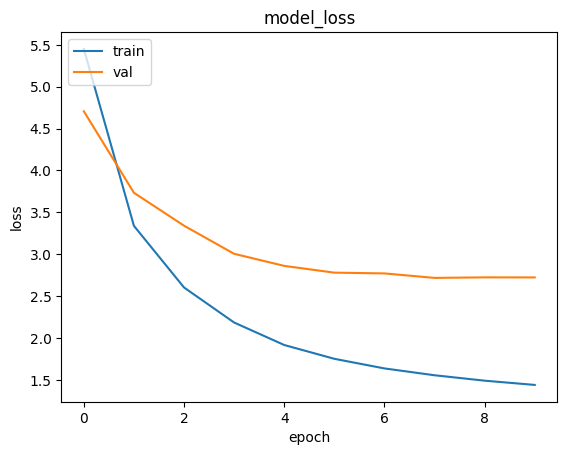

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
transformer.evaluate(val_dataset)

375/375 [==============================] - 53s 46ms/step - loss: 2.7233


2.7233364582061768

# Testing

In [ ]:
index_to_word={x:y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [ ]:
def translator(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken'

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vectorize_layer([shifted_target])
    output=transformer.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[french_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [ ]:
translator('What makes you think that it is not true?')

1/1 [==============================] - 0s 42ms/step


'questce qui te fait penser que ce nest pas vrai'

In [ ]:
translator('Have you ever watched soccer under the rain?')

1/1 [==============================] - 0s 45ms/step


'astu déjà regardé au foot sous la pluie'

In [ ]:
translator("what is your name?")

1/1 [==============================] - 0s 49ms/step


'quel est ton nom de ton nom'

In [ ]:
translator('Great trees do not grow with ease, the stronger the winds, the stronger the trees')

1/1 [==============================] - 0s 27ms/step


'de grands arbres ne font pas de tête à la plus grande'

In [ ]:
translator('My hotel told me to call you. ')

1/1 [==============================] - 0s 28ms/step


'mon hôtel ma dit de vous appeler'

In [ ]:
translator('His French is improving little by little')

1/1 [==============================] - 0s 30ms/step


'son français devient peu peu de peu'

In [ ]:
translator('I love to write')

1/1 [==============================] - 0s 27ms/step


'jaime écrire à écrire'

In [ ]:
translator('Perhaps she will come tomorrow')

1/1 [==============================] - 0s 32ms/step


'peutêtre quelle viendra demain'

In [ ]:
translator('Tom has never heard Mary sing.')

1/1 [==============================] - 0s 30ms/step


'tom na jamais entendu mary chanter'

In [ ]:
translator('She handed him the money')

1/1 [==============================] - 0s 28ms/step


'elle lui a donné largent de largent'

# Visualization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def visualize(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken je lai fait très bien'

  tokenized_shifted_target=french_vectorize_layer([shifted_target])
  attention_weights=attention_score_model.predict([tokenized_english_sentence,
                                                   tokenized_shifted_target])

  return attention_weights

out=visualize('I did it very well')


In [ ]:
print(out['decoder_layer1_block2'][0].shape)

(8, 64, 64)


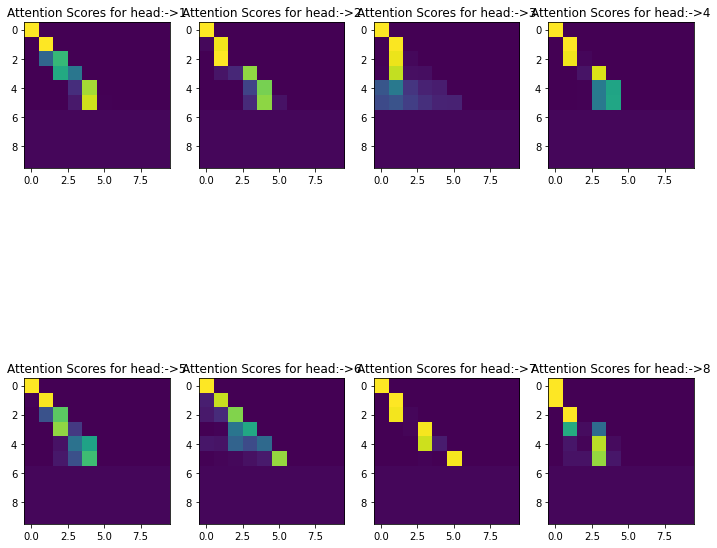

In [ ]:
plt.figure(figsize = (12,12))

for i in range(NUM_HEADS):
  ax = plt.subplot(2,4, i+1)

  plt.imshow(out['decoder_layer1_block2'][0][i][0:10,0:10])
  plt.title("Attention Scores for head:->"+str(i+1))

In [ ]:
!pip install aicrowd-cli

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 4.0 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 1.1 MB 44.1 MB/s 
     |████████████████████████████████| 170 kB 72.7 MB/s 
     |████████████████████████████████| 214 kB 61.2 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 51 kB 7.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 23.2.1
    Uninstalling pyzmq-23.2.1:
      Successfully uninstalled pyzmq-23.2.1
  Attempting uninstall: python-slugify
    Found existing installation: python-slugify 6.1.2
    Uninstalling python-slugify-6.1.2:
 

In [ ]:
!aicrowd login

Please login here: https://api.aicrowd.com/auth/wtHm9oiaN9-I--I4Ivn1eRDGXB7IG6YYX1nlj37hllk
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'https://api.aicrowd.com/auth/wtHm9oiaN9-I--I4Ivn1eRDGXB7IG6YYX1nlj37hllk'
API Key valid
Gitlab access token valid
Saved details successfully!


In [ ]:
!aicrowd dataset download -c esci-challenge-for-improving-product-search

product_catalogue-v0.3.csv.zip: 100% 328M/328M [00:16<00:00, 20.1MB/s]
sample_submission_public-v0.3.csv.zip: 100% 331k/331k [00:00<00:00, 587kB/s]
test_public-v0.3.csv.zip: 100% 394k/394k [00:00<00:00, 690kB/s]
train-v0.3.csv.zip: 100% 6.80M/6.80M [00:01<00:00, 5.95MB/s]
product_catalogue-v0.3.csv.zip: 100% 657M/657M [00:31<00:00, 21.1MB/s]
sample_submission_public-v0.3.csv.zip: 100% 812k/812k [00:00<00:00, 1.15MB/s]
test_public-v0.3.csv.zip: 100% 2.94M/2.94M [00:01<00:00, 2.94MB/s]
train-v0.3.csv.zip: 100% 19.8M/19.8M [00:01<00:00, 11.4MB/s]
product_catalogue-v0.3.csv.zip: 100% 657M/657M [00:42<00:00, 15.5MB/s]
sample_submission_public-v0.3.csv.zip: 100% 803k/803k [00:00<00:00, 1.12MB/s]
test_public-v0.3.csv.zip: 100% 2.94M/2.94M [00:00<00:00, 2.97MB/s]
train-v0.3.csv.zip: 100% 20.3M/20.3M [00:01<00:00, 10.9MB/s]


In [ ]:
!unzip "/content/product_catalogue-v0.3.csv.zip" -d "/content/dataset/"

Archive:  /content/product_catalogue-v0.3.csv.zip
  inflating: /content/dataset/data/processed/public/task_3_product_substitute_identification/product_catalogue-v0.3.csv  


In [ ]:
filepath='/content/dataset/data/processed/public/task_3_product_substitute_identification/product_catalogue-v0.3.csv'

In [ ]:
import pandas as pd

df = pd.read_csv(filepath)


In [ ]:
len(df)

1815216

In [ ]:
df[1600000:1600050]

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color_name,product_locale
1600000,B07RK154DV,"Stemless Wine Tumbler with Lid and Straw, Bast...",<b>Bastwe 4 Pack 12oz Vacuum Insulated Wine Tu...,💥 Food Grade Stainless Steel: The wine glass i...,Bastwe,Black,us
1600001,B07T3SLJQ7,PURECUP 12 oz Wine Tumbler With Spill-proof Li...,<b>Specification:</b><br>*Designs: Stainless W...,12OZ insulated stainless stell wine glasses wi...,PURECUP,Aqua Blue,us
1600002,B07TF6JXSG,Comfook Glass Bulk Set Wine Cups Glasses with ...,NaN,For Any Occasion: 12 oz glass is in a beautifu...,Comfook,Multicolor B,us
1600003,B07VH1XG7J,Deitybless 6 Pack 12 oz Stainless Steel Wine T...,Deitybless pack wine tumbler cup with lids 12 ...,【HIGHT QUALITY】The wine tumbler is made of goo...,Deitybless,Assorted Colors_6 pack(with straws),us
1600004,B0822R1N1K,Vacuum Insulated Wine Tumbler with Sliding Lid...,<b>LEVIN Vacuum Insulated Wine Tumbler with Sl...,【Preserve the Most Wanted Temp & Flavour】 Adop...,LEVIN,Black,us
1600005,B082SC54BP,MUCHENGHY 12 oz Wine Glass Tumbler Bulk with L...,<p>Mucheng Vacuum Insulated Wine Tumbler with ...,【GIVE AS A PRESENT TO COMMEMORATE!】 It's strik...,MUCHENGHY,Rose Gold,us
1600006,B01M71BZD9,Yedi 9-in-1 Total Package Instant Programmable...,NaN,OPRAH’S FAVORITE THINGS: The Yedi 9-in-1 Total...,YEDI HOUSEWARE,Stainless Steel,us
1600007,B01NBKTPTS,Instant Pot Duo Plus 6 Quart 9-in-1 Electric P...,NaN,"SIMPLE, STRESS-FREE VENTING with an intuitive ...",Instant Pot,Stainless Steel/Black,us
1600008,B0777XQ4S8,Instant Pot Smart Wifi 6 Quart Multi-use Elect...,NaN,Cooks fast and saves time: The Instant Pot Sma...,Instant Pot,Silver,us
1600009,B077T9YGRM,Instant Pot Max 6 Quart Multi-use Electric Pre...,NaN,"Sustained 15psi, not only cooks food faster, y...",Instant Pot,Silver,us


In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self,transformer):
    super(Transformer,self).__init__()
    self.transformer=transformer

  def compile(self,loss_fn,optimizer):
    super(Transformer,self).compile()
    self.optimizer=optimizer
    self.loss_fn=loss_fn
    self.loss_metric=tf.keras.metrics.Mean(name='loss')

  @property
  def metrics(self):
    return [self.loss_metric,]

  def train_step(self,x_y):
    inputs,target=x_y
    encoder_input=inputs['input_1']
    shifted_target=inputs['input_2']

    with tf.GradientTape() as recorder:

      output,_=self.transformer([encoder_input,shifted_target])
      loss=self.loss_fn(target,output)

    partial_derivatives = recorder.gradient(loss,self.transformer.trainable_weights)
    self.optimizer.apply_gradients(zip(partial_derivatives, self.transformer.trainable_weights))

    self.loss_metric.update_state(loss)

    return {'loss':self.loss_metric.result()}